In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc ,random 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import model_selection

import cv2
import SimpleITK as sitk
from ipywidgets import interact, fixed
from tqdm import tqdm 
import matplotlib.pyplot as plt
from PIL import Image


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import albumentations as A 

from collections import OrderedDict
from sklearn.model_selection import train_test_split

from loss.ssim import * 
from models.UNet import *
from datasets.merging_dataset import * 

device = torch.device('cuda')

In [3]:
df = pd.read_csv('data_5fold.csv')
subjects = df[df['slice']==0]

In [4]:
class Adeversarial(nn.Module) : 
    def __init__(self) : 
        super(Adeversarial, self).__init__()
        
        self.image_encoder = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128 , kernel_size = 5), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size = 2 , stride=2),
        
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 2, kernel_size=3),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Sigmoid()
        
        )
        
    def forward(self, image):
        y = self.image_encoder(image)
        return(y[:,:,0,0])           

In [5]:
class CascadedUNet(nn.Module) : 
    def __init__(self) :
        super(CascadedUNet,self).__init__()
        self.layer_1  = UNet(1,1, segmentation = False) 
        self.layer_2  = UNet(2,4, segmentation = False)
        self.layer_3  = UNet(6,1, segmentation = False)
        self.layer_4  = UNet(2,4, segmentation = False)
        self.layer_5  = UNet(6,1, segmentation = False)
    def forward(self,image) :
        
        hr_1 = self.layer_1(image)
        im = torch.cat([hr_1,image],dim=1)
        
        seg_1 = self.layer_2(im)
        
        seg_t = self.segmentation_gen(seg_1)
        im = torch.cat([hr_1,image,seg_t*image],dim=1)
        
        hr_2 = self.layer_3(im) 
        
        im = torch.cat([hr_2,image],dim=1)
        seg_2 = self.layer_4(im)
        
        seg_t = self.segmentation_gen(seg_2) 
        
        im = torch.cat([hr_2,image,seg_t*image],dim=1)
        hr_3 = self.layer_5(im)
        
        return hr_3
    def segmentation_gen(self,x) : 
        
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        y_1 = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        y_1 = y_1.type(torch.float)
        
        return y_1 
        

In [6]:
class ParallelCascadedUNet(nn.Module) : 
    def __init__(self) :
        super(ParallelCascadedUNet,self).__init__()
        
        self.segmentation_1  = UNet(1,4, segmentation = False) 
        self.segmentation_2  = UNet(2,4, segmentation = False)
        self.segmentation_3  = UNet(2,4, segmentation = False)
        
        self.reconstruction_1 = UNet(1,1, segmentation = False)
        self.reconstruction_2 = UNet(5,1, segmentation = False)
        self.reconstruction_3 = UNet(5,1, segmentation = False)
    
    def forward(self,image) :
        seg_1 = self.segmentation_1(image) 
        rec_1 = self.reconstruction_1(image)
        
        x_hr_lr = torch.cat([rec_1,image] , dim =1)
        seg_2  = self.segmentation_2(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_1)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_2 = self.reconstruction_2(x_merge)
        
        x_hr_lr = torch.cat([rec_2,image] , dim =1)
        seg_3  = self.segmentation_3(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_2)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_3 = self.reconstruction_3(x_merge)
        
        return rec_3
    def construct_seg(self,x) : 
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        generated_segmenation = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        generated_segmenation = generated_segmenation.type(torch.float)
        return generated_segmenation 

In [7]:
class GANCascadedUNet(nn.Module) : 
    def __init__(self) :
        super(GANCascadedUNet,self).__init__()
        self.layer_1  = UNet(1,1, segmentation = False) 
        self.layer_2  = UNet(2,4, segmentation = False)
        self.layer_3  = UNet(6,1, segmentation = False)
        self.layer_4  = UNet(2,4, segmentation = False)
        self.layer_5  = UNet(6,1, segmentation = False)
    def forward(self,image) :
        
        hr_1 = self.layer_1(image)
        im = torch.cat([hr_1,image],dim=1)
        
        seg_1 = self.layer_2(im)
        
        seg_t = self.segmentation_gen(seg_1)
        im = torch.cat([hr_1,image,seg_t*image],dim=1)
        
        hr_2 = self.layer_3(im) 
        
        im = torch.cat([hr_2,image],dim=1)
        seg_2 = self.layer_4(im)
        
        seg_t = self.segmentation_gen(seg_2) 
        
        im = torch.cat([hr_2,image,seg_t*image],dim=1)
        hr_3 = self.layer_5(im)
        
        return hr_3  
    def segmentation_gen(self,x) : 
        
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        y_1 = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        y_1 = y_1.type(torch.float)
        
        return y_1 
        

In [8]:
class GANParallelCascadedUNet(nn.Module) : 
    def __init__(self) :
        super(GANParallelCascadedUNet,self).__init__()
        
        self.segmentation_1  = UNet(1,4, segmentation = False) 
        self.segmentation_2  = UNet(2,4, segmentation = False)
        self.segmentation_3  = UNet(2,4, segmentation = False)
        
        self.reconstruction_1 = UNet(1,1, segmentation = False)
        self.reconstruction_2 = UNet(5,1, segmentation = False)
        self.reconstruction_3 = UNet(5,1, segmentation = False)
    
    def forward(self,image) :
        seg_1 = self.segmentation_1(image) 
        rec_1 = self.reconstruction_1(image)
        
        x_hr_lr = torch.cat([rec_1,image] , dim =1)
        seg_2  = self.segmentation_2(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_1)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_2 = self.reconstruction_2(x_merge)
        
        x_hr_lr = torch.cat([rec_2,image] , dim =1)
        seg_3  = self.segmentation_3(x_hr_lr) 
        
        c_seg = self.construct_seg(seg_2)
        x_merge = torch.cat([image,c_seg] , dim = 1 )
        rec_3 = self.reconstruction_3(x_merge)
       
        pred_seg = self.construct_seg(seg_3)
        return rec_3
    
    def construct_seg(self,x) : 
        y_1 = torch.argmax(nn.Softmax2d()(x) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        generated_segmenation = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        generated_segmenation = generated_segmenation.type(torch.float)
        return generated_segmenation 
        

In [26]:
def construction(df , model , is_simple = True) : 
    model.eval()
    data_loader = torch.utils.data.DataLoader(
        df,
        batch_size=8,
        num_workers=4
    )
    with torch.no_grad():
        
        for bi, d in tqdm(enumerate(data_loader)) :
       
            y = d["HR"].to(device, dtype=torch.float)

            x = d["LR"].to(device, dtype=torch.float) 
            
            y_hat   = model(x.unsqueeze(1)) #forward prop
            if is_simple == False : 
                y_hat = y_hat[:,1:,:,:]
            if bi == 0 :
                
                full_x     = x
                full_y     = y
                full_y_hat = y_hat 
            
            else :
                
                full_x     = torch.cat([full_x , x] , dim = 0 ) 
                full_y     = torch.cat([full_y , y] , dim = 0 )  
                full_y_hat = torch.cat([full_y_hat , y_hat] , dim = 0 )  
                
    return full_x.cpu().numpy() , full_y.cpu().numpy() , full_y_hat.cpu().numpy()[:,0,:,:]

In [27]:
def write( x , path ) :  
    img = sitk.GetImageFromArray(x)
    writer = sitk.ImageFileWriter()
    writer.SetFileName(path)
    writer.Execute(img)

In [28]:
def generate_subject(subject_num , f):

        PATH_UNet = f'trained_model/UNet_reconstruction/Unet Left fold {f}.pt'
        PATH_GAN = f'trained_model/GAN_reconstruction/GAN Left fold {f}.pt'
        PATH_CUNet = f'trained_model/Casceded UNet/Rec Cascaded Unet V2 Left fold {f}.pt'
        PATH_PCUNet = f'trained_model/PCasceded UNet/Rec PCascaded Unet V2 Left fold {f}.pt'
        PATH_GANCUNet = f'trained_model/Casceded UNet/GAN Rec Cascaded Unet V2 Left fold {f}.pt'
        PATH_GANPCUNet = f'trained_model/PCasceded UNet/GAN Rec PCascaded Unet V2 Left fold {f}.pt'
        
        subject_df = df[df['Subject_num']==subject_num ]
        subject_df = subject_df.sort_values('slice')
        
        subject_df_dataset =  Merging_data_set(subject_df ,  subjects  , Left = True , is_train = False)
        
        model = UNet(1,1)
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_UNet))
        x , y , y_hat = construction(subject_df_dataset,model)
      
        
        write(x,f'models_outputs/Reconstruction/Fold {f}/Orginal_LR_subject_num_{subject_num}_fold_{f}.nii')   
        write(y,f'models_outputs/Reconstruction/Fold {f}/Orginal_HR_subject_num_{subject_num}_fold_{f}.nii')
        write(y_hat,f'models_outputs/Reconstruction/Fold {f}/UNet_predicted_HR_subject_num_{subject_num}_fold_{f}.nii')
        
        
        model = UNet(1,1)
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_GAN))
        x , y , y_hat = construction(subject_df_dataset,model)
        write(y_hat,f'models_outputs/Reconstruction/Fold {f}/GAN_predicted_HR_subject_num_{subject_num}_fold_{f}.nii')

        model = CascadedUNet()
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_CUNet))
        x , y , y_hat = construction(subject_df_dataset,model)
        write(y_hat,f'models_outputs/Reconstruction/Fold {f}/CUNet_predicted_HR_subject_num_{subject_num}_fold_{f}.nii')
        
        model = ParallelCascadedUNet()
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_PCUNet))
        x , y , y_hat = construction(subject_df_dataset,model) 
        write(y_hat,f'models_outputs/Reconstruction/Fold {f}/PCUNet_predicted_HR_subject_num_{subject_num}_fold_{f}.nii')
        
        model = GANCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANCUNet))
        x , y , y_hat = construction(subject_df_dataset,model)
        write(y_hat,f'models_outputs/Reconstruction/Fold {f}/GANCUNet_predicted_HR_subject_num_{subject_num}_fold_{f}.nii')
        
        model = GANParallelCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANPCUNet))
        x , y , y_hat = construction(subject_df_dataset,model)
        write(y_hat,f'models_outputs/Reconstruction/Fold {f}/GANPCUNet_predicted_HR_subject_num_{subject_num}_fold_{f}.nii')
              
        

In [29]:
subject_fold0 = 7
subject_fold1 = 23
subject_fold2 = 15
subject_fold3 = 10
subject_fold4 = 5

In [30]:
generate_subject(7,0)
generate_subject(23,1)
generate_subject(15,2)
generate_subject(10,3)
generate_subject(5,4)


(159, 160, 160)
(159, 160, 160)
(159, 160, 160)



(159, 160, 160)
(159, 160, 160)
(159, 160, 160)



(159, 160, 160)
(159, 160, 160)
(159, 160, 160)



(159, 160, 160)
(159, 160, 160)
(159, 160, 160)



(159, 160, 160)
(159, 160, 160)
(159, 160, 160)


In [31]:
def display_images(image_lr, image_reconstruct, image_hr, z):
    fig, axs = plt.subplots(1,3,figsize=(20,8))
    axs[0].imshow(sitk.GetArrayFromImage(image_lr[:,:,z]),cmap=plt.cm.Greys_r);
    axs[0].set_title('3T LR')
    axs[2].imshow(sitk.GetArrayFromImage(image_hr[:,:,z]),cmap=plt.cm.Greys_r);
    axs[2].set_title('3T HR')
    axs[1].imshow(sitk.GetArrayFromImage(image_reconstruct[:,:,z]),cmap=plt.cm.Greys_r);
    axs[1].set_title('3T like HR')

In [34]:
predicted_img = sitk.ReadImage( 'models_outputs/Reconstruction/Fold 0/UNet_predicted_HR_subject_num_7_fold_0.nii')
real_lr = sitk.ReadImage( 'models_outputs/Reconstruction/Fold 0/Orginal_LR_subject_num_7_fold_0.nii')
real_hr = sitk.ReadImage( 'models_outputs/Reconstruction/Fold 0/Orginal_HR_subject_num_7_fold_0.nii')

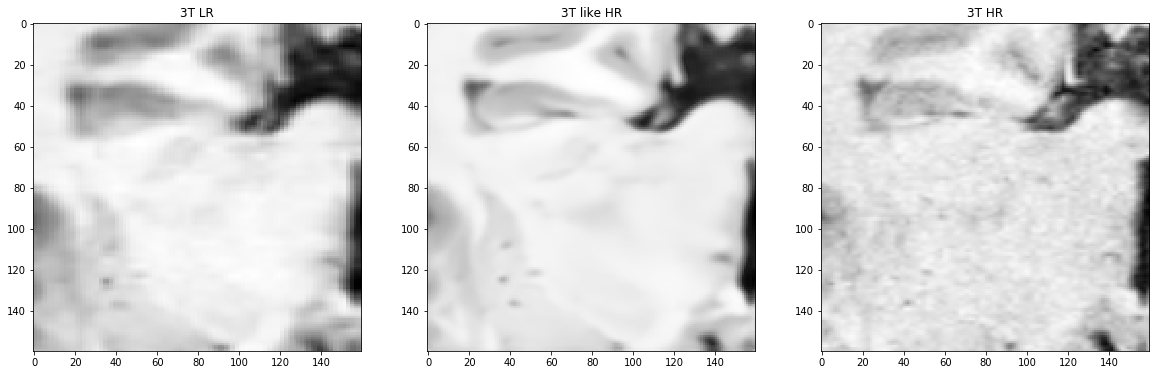

<function __main__.display_images(image_lr, image_reconstruct, image_hr, z)>

In [35]:
interact(display_images, z=(0, real_lr.GetSize()[2] - 1), image_lr = fixed(real_lr), image_reconstruct = fixed(predicted_img) ,image_hr = fixed(real_hr) )


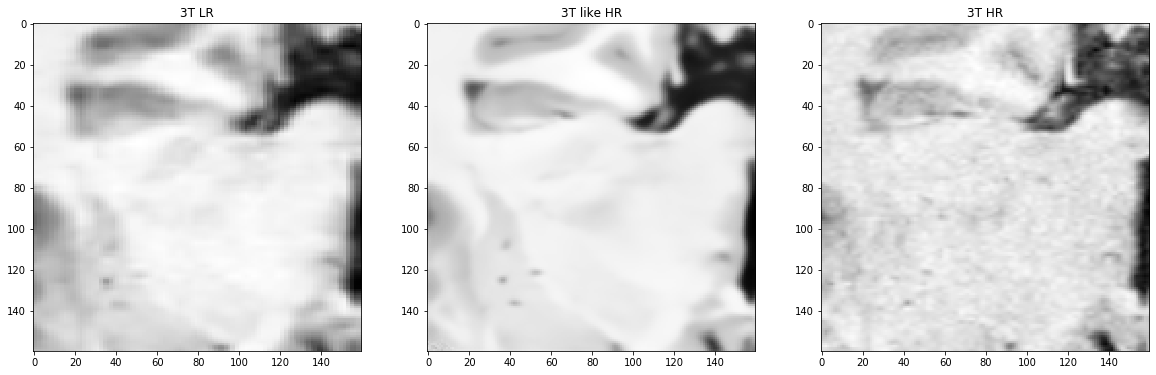

<function __main__.display_images(image_lr, image_reconstruct, image_hr, z)>

In [33]:
interact(display_images, z=(0, real_lr.GetSize()[2] - 1), image_lr = fixed(real_lr), image_reconstruct = fixed(predicted_img) ,image_hr = fixed(real_hr) )


In [22]:
predicted_img.GetSize()

(160, 1, 159)